In [40]:
import sys
import os
import pandas as pd
scripts_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts'))
sys.path.append(scripts_dir)
from data_generator import normalize, normalize_new_data


In [41]:
#Full CSV Files
rainfall =pd.read_csv(r"..\data\final_data\rainfall.csv")
air_temperature = pd.read_csv(r"..\data\final_data\air_temperature.csv")
wind_speed = pd.read_csv(r"..\data\final_data\wind_speed.csv")
relative_humidity = pd.read_csv(r"..\data\final_data\relative_humidity.csv")
wind_direction = pd.read_csv(r"..\data\final_data\wind_direction.csv")
lightning_risk_16S = pd.read_csv(r"..\data\final_data\Lightning Risk 16S.csv") # Output
input_data_dfs = [rainfall, air_temperature, wind_speed, relative_humidity, wind_direction]
input_data_df_names = ["rainfall", "air_temperature", "wind_speed", "relative_humidity", "wind_direction"]

In [42]:
normalized_dfs = []
for i in range(len(input_data_dfs)):
    normalize(input_data_dfs[i], input_data_df_names[i])
    normalized_dfs.append(normalize_new_data(input_data_dfs[i], input_data_df_names[i]))

Zero Replace: 3.7037037037036997e-08
Done saving scaler object and param dict.
Done normalizing
Zero Replace: 0.00021
Done saving scaler object and param dict.
Done normalizing
Zero Replace: 4.27480916030534e-07
Done saving scaler object and param dict.
Done normalizing
Zero Replace: 0.000321
Done saving scaler object and param dict.
Done normalizing
Zero Replace: 1e-05
Done saving scaler object and param dict.
Done normalizing


In [43]:
os.makedirs("../data/normalized_data/",exist_ok=True)

In [44]:
for i in range(len(input_data_df_names)):
    normalized_dfs[i].to_csv(os.path.join("../data/normalized_data/",input_data_df_names[i]+".csv"))

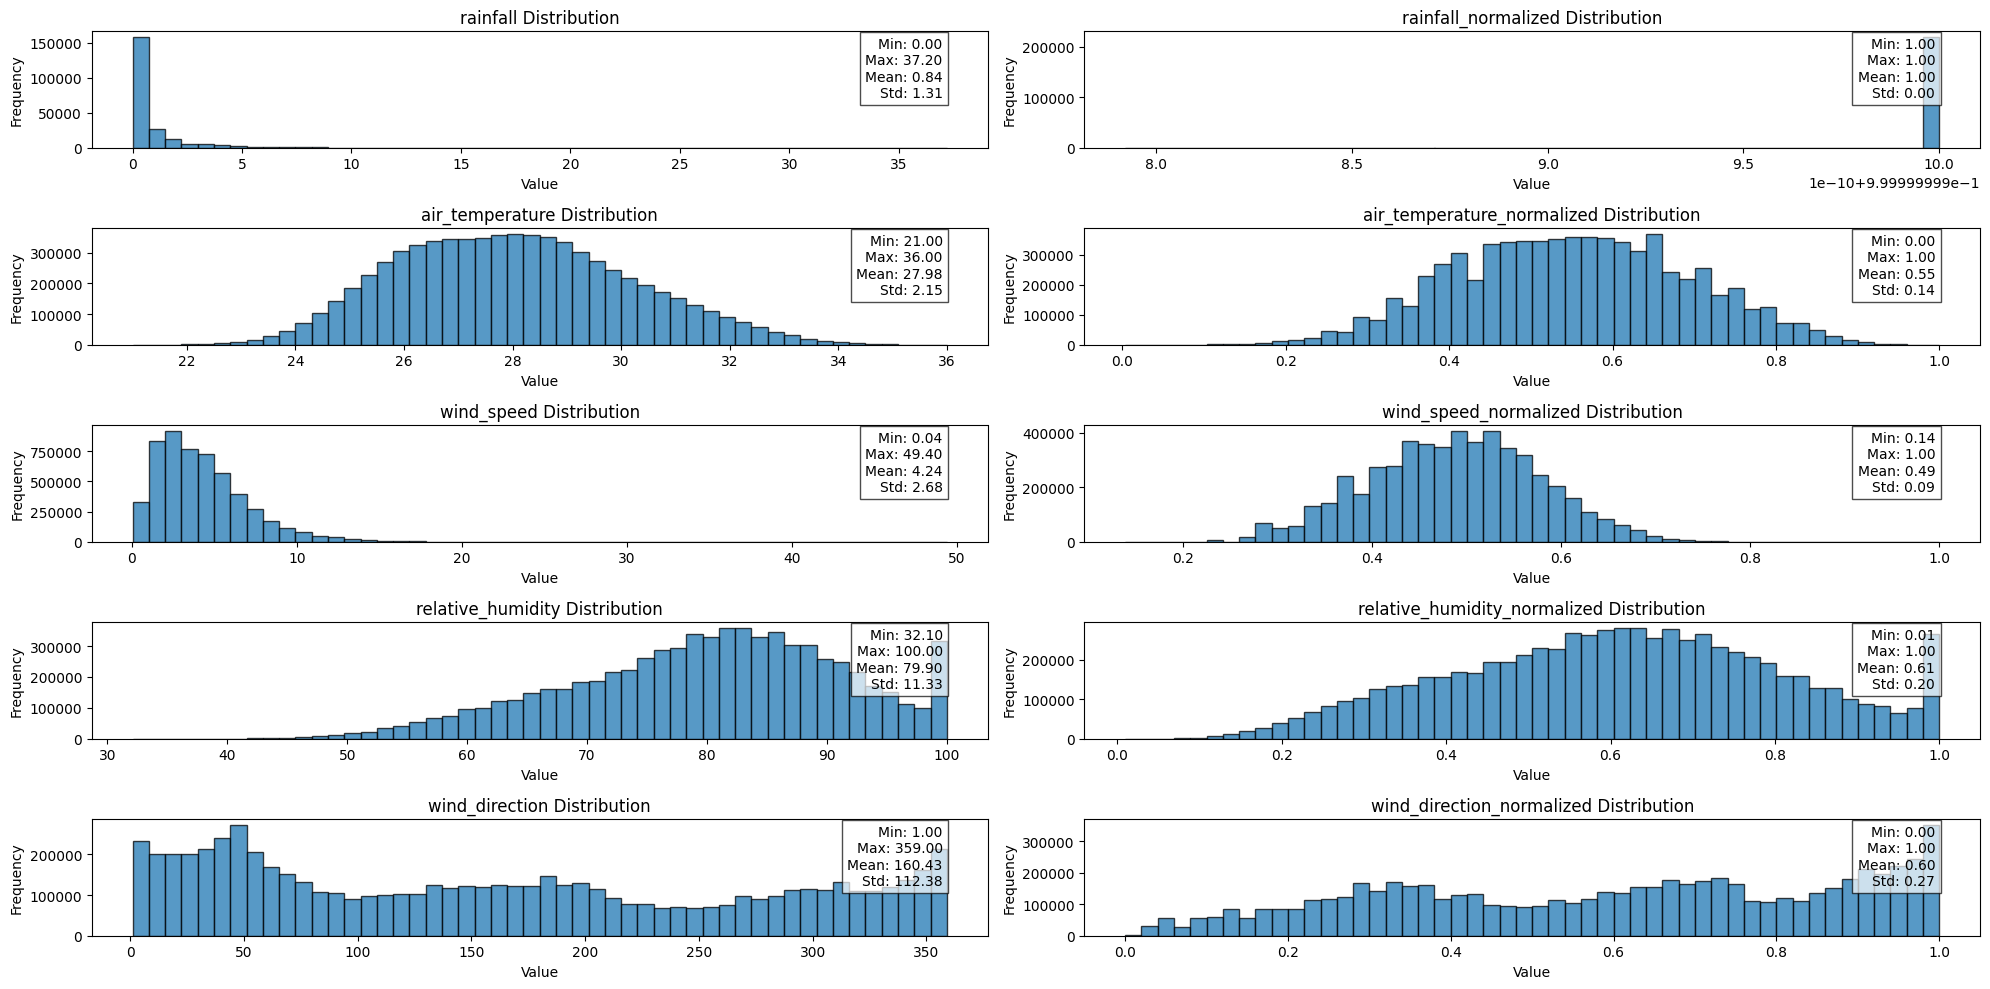

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a 2x2 subplot layout
fig, axes = plt.subplots(5, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten for easy iteration

for i, (df, name) in enumerate(zip(input_data_dfs+normalized_dfs, input_data_df_names+[i+"_normalized" for i in input_data_df_names])):
    # Select only numerical columns (excluding Timestamp)
    df_values = df.drop(columns=["Timestamp"], errors="ignore").melt().value.dropna()
    df_values = df_values[df_values>0]
    # Convert to float
    df_values = df_values.astype(float)
    # Calculate statistics
    min_val = df_values.min()
    max_val = df_values.max()
    mean_val = df_values.mean()
    std_val = df_values.std()

    # Plot histogram
    axes[i*2 if i < 5 else (i-5)*2+1].hist(df_values, bins=50, alpha=0.75, edgecolor="black")
    axes[i*2 if i < 5 else (i-5)*2+1].set_title(f"{name} Distribution")
    axes[i*2 if i < 5 else (i-5)*2+1].set_xlabel("Value")
    axes[i*2 if i < 5 else (i-5)*2+1].set_ylabel("Frequency")
    stats_text = f"Min: {min_val:.2f}\nMax: {max_val:.2f}\nMean: {mean_val:.2f}\nStd: {std_val:.2f}"
    axes[i*2 if i < 5 else (i-5)*2+1].text(0.95, 0.95, stats_text, transform=axes[i*2 if i < 5 else (i-5)*2+1].transAxes,
                 fontsize=10, verticalalignment='top', horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

plt.tight_layout()
plt.show()

In [46]:
#Gathered from data_cleaning_v2.ipynb
station_ids = ['S100', 'S104', 'S106', 'S107', 'S108', 'S109', 'S111', 'S115', 'S116', 'S117', 'S121', 'S24', 'S43', 'S44', 'S50', 'S60']

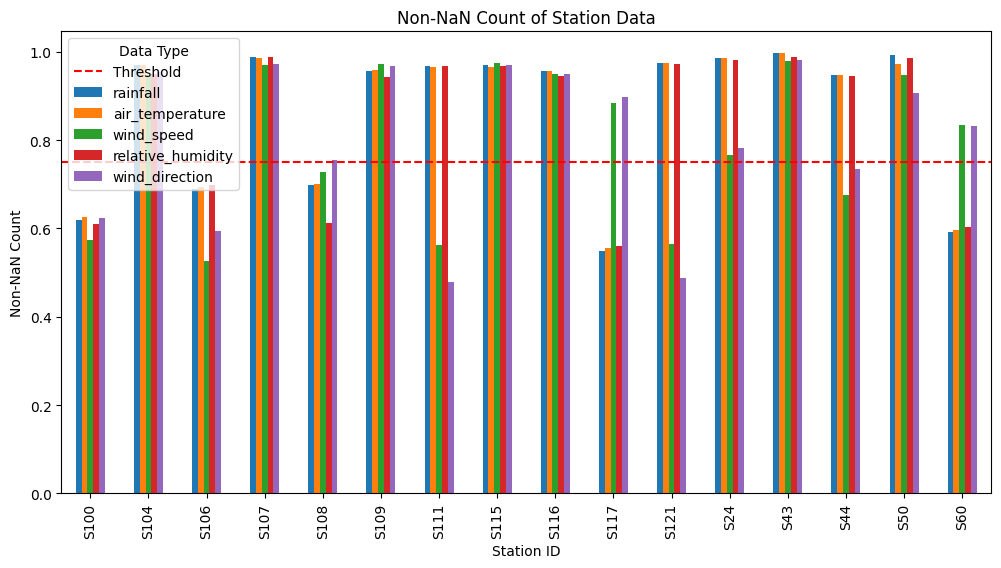

In [47]:

# Dictionary to store non-NaN counts
non_nan_counts = {}

# Compute non-NaN counts for each station_id in each dataframe
for df_name, df in zip(input_data_df_names, input_data_dfs):
    non_nan_counts[df_name] = df[station_ids].count() / df.shape[0]  # Normalized by row count


# Convert to DataFrame for visualization
non_nan_counts_df = pd.DataFrame(non_nan_counts)

# Plot bar chart
non_nan_counts_df.plot(kind="bar", figsize=(12, 6))
plt.xlabel("Station ID")
plt.ylabel("Non-NaN Count")
plt.title("Non-NaN Count of Station Data")
plt.xticks(rotation=90)
threshold_value = 0.75  # Change this to your desired threshold
plt.axhline(y=threshold_value, color='r', linestyle='--', label="Threshold")
plt.legend(title="Data Type")
plt.show()




In [48]:
# Keep only station IDs where all datasets have >= threshold
stations_to_keep = non_nan_counts_df[non_nan_counts_df >= threshold_value].dropna(axis=0, how='any').index.tolist()

print(f"Station IDs kept (>= {threshold_value:.0%} non-NaN in all datasets):")
print(stations_to_keep)

# Now filter each input dataframe to keep only these stations
filtered_input_data_dfs = [
    df[["Timestamp"] + stations_to_keep] if "Timestamp" in df.columns else df[stations_to_keep]
    for df in normalized_dfs
]

Station IDs kept (>= 75% non-NaN in all datasets):
['S104', 'S107', 'S109', 'S115', 'S116', 'S24', 'S43', 'S50']


In [49]:
all_dfs = filtered_input_data_dfs + [lightning_risk_16S]

for i in range(len(all_dfs)):
    all_dfs[i].reset_index(inplace=True)  # Moves index to a column
    all_dfs[i]["Timestamp"] = pd.to_datetime(all_dfs[i]["Timestamp"])

# Find the minimum and maximum timestamp across all datasets
min_timestamp = max(df["Timestamp"].min() for df in all_dfs)
max_timestamp = min(df["Timestamp"].max() for df in all_dfs)

print(f"Common Time Range: {min_timestamp} to {max_timestamp}")

# Filter each dataset to keep only the common time range
for i in range(len(all_dfs)):
    all_dfs[i] = all_dfs[i][(all_dfs[i]["Timestamp"] >= min_timestamp) & 
                            (all_dfs[i]["Timestamp"] <= max_timestamp)]
# Merge the filtered datasets
compiled_dfs = []
for df, name in zip(filtered_input_data_dfs, input_data_df_names):
    renamed_df = df.rename(columns={col: f"{name}_{col}" for col in station_ids})
    compiled_dfs.append(renamed_df)

# Merge all datasets on Timestamp
compiled_df = compiled_dfs[0]
for df in compiled_dfs[1:]:
    compiled_df = compiled_df.merge(df, on="Timestamp", how="outer")

# Merge lightning risk data
compiled_df = compiled_df.merge(lightning_risk_16S[["Timestamp", "16S"]], on="Timestamp", how="outer")
compiled_df = compiled_df.rename(columns={"16S": "Lightning_Risk"})
# Display final structure
compiled_df.head()


C:\Users\tomma\AppData\Local\Temp\ipykernel_44896\833174267.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dfs[i]["Timestamp"] = pd.to_datetime(all_dfs[i]["Timestamp"])
C:\Users\tomma\AppData\Local\Temp\ipykernel_44896\833174267.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dfs[i]["Timestamp"] = pd.to_datetime(all_dfs[i]["Timestamp"])
C:\Users\tomma\AppData\Local\Temp\ipykernel_44896\833174267.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Common Time Range: 2020-04-29 00:00:00+08:00 to 2024-12-31 23:55:00+08:00


,Timestamp,rainfall_S104,rainfall_S107,rainfall_S109,rainfall_S115,rainfall_S116,rainfall_S24,rainfall_S43,rainfall_S50,air_temperature_S104,...,relative_humidity_S50,wind_direction_S104,wind_direction_S107,wind_direction_S109,wind_direction_S115,wind_direction_S116,wind_direction_S24,wind_direction_S43,wind_direction_S50,Lightning_Risk
0,2020-04-01 00:00:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.540197,...,0.583237,0.304341,0.183327,0.231367,0.396926,0.189855,0.290998,0.341646,0.321385,NaN
1,2020-04-01 00:05:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.533514,...,0.579704,0.308678,0.155171,0.214371,0.349461,0.169696,0.299950,0.299950,0.321385,NaN
2,2020-04-01 00:10:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.533514,...,0.585007,0.304341,0.169696,0.208459,0.321385,0.122552,0.329620,0.286433,0.321385,NaN
3,2020-04-01 00:15:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.533514,...,0.588553,0.299950,0.220155,0.196212,0.345573,0.041682,0.345573,0.262607,0.295503,NaN
4,2020-04-01 00:20:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.533514,...,0.592108,0.308678,0.252551,0.202409,0.357126,0.070249,0.349461,0.252551,0.272349,NaN


In [50]:
cleaned_compiled_df = compiled_df.dropna()

In [51]:
print(len(compiled_df),len(cleaned_compiled_df))

527804 221369


In [54]:
# Split DataFrame into two halves
halfway_index = len(cleaned_compiled_df) // 2

# Save the first half
cleaned_compiled_df[:halfway_index].to_csv("../data/final_data/cleaned_compiled_data_normalized_part1.csv", index=False)

# Save the second half
cleaned_compiled_df[halfway_index:].to_csv("../data/final_data/cleaned_compiled_data_normalized_part2.csv", index=False)


In [53]:
import pyarrow.feather as feather
feather.write_feather(cleaned_compiled_df, "../data/final_data/cleaned_compiled_data_normalized.feather")
